## Imports

In [1]:
using LinearAlgebra
using MultivariateStats
using LaTeXStrings, Plots
using QHull
using StatsBase
using JuMP
using LazySets
import HiGHS
# Look into Revise.jl
include("visual_helpers.jl")

solve_cheb (generic function with 1 method)

## First define the MDP

In [2]:

γ::Float64 = 0.99 # Discount
p₀::Vector{Float64} = [0.1, 0.7, 0.2] # Inital state distribution
S::Vector{Int} = [1, 2, 3] # Three states
A::Vector{Int} = [1, 2] # Two actions in each state

#Transition probabilities
# Index by [s, s', a]
P = [0.6; 0; 0.3;; 0.4; 0; 0.7;;0;1;0;;; 0;1;0.2;;0.2;0;0.1;;0.8;0;0.7]


3×3×2 Array{Float64, 3}:
[:, :, 1] =
 0.6  0.4  0.0
 0.0  0.0  1.0
 0.3  0.7  0.0

[:, :, 2] =
 0.0  0.2  0.8
 1.0  0.0  0.0
 0.2  0.1  0.7

## Construct the set of all occupancy frequencies

The following occupancy frequencies are extreme points of the convex set of occupancy
frequencies in this problem.

In [3]:
U = construct_U(S, A, P, γ, p₀)


# U is a vector of matricies
# each u ∈ U is a matrix of SxA
# u is indexed by [s, a]
display(U)
@show sum.(U)

8-element Vector{Matrix{Real}}:
 [26.91670372151673 0.0; 36.624771999237474 0.0; 36.4585242792451 0.0]
 [0.0 14.477407817040733; 37.11381165420244 0.0; 48.40878052875668 0.0]
 [70.88925501432638 0.0; 0.0 28.910744985673244; 0.2 0.0]
 [0.0 38.97873687991737; 0.0 29.950103511187567; 31.071159608894558 0.0]
 [27.361258341382868 0.0; 17.03939374648834 0.0; 0.0 55.59934791212851]
 [0.0 14.796617881700614; 10.978039281427028 0.0; 0.0 74.22534283687179]
 [70.6189391747475 0.0; 0.0 28.72959502720652; 0.0 0.6514657980456026]
 [0.0 24.443100192699905; 0.0 11.847012665220422; 0.0 63.709887142079225]

sum.(U) = [99.9999999999993, 99.99999999999986, 99.99999999999963, 99.99999999999949, 99.99999999999972, 99.99999999999943, 99.99999999999962, 99.99999999999955]


8-element Vector{Float64}:
 99.9999999999993
 99.99999999999986
 99.99999999999963
 99.99999999999949
 99.99999999999972
 99.99999999999943
 99.99999999999962
 99.99999999999955

## Compute Features via PCA

In [4]:
UM = Float64.(reduce(hcat, vec.(U))) # This line took me nearly a century
display(UM) # UM : Matrix where each col is a occ freq (for PCA reasons)

M = fit(PCA, UM, maxoutdim=2)
Φ = projection(M) # Feature matrix

display(Φ)
# Φ[:,1] = Φ[:,1] * 2
# Φ[:,2] = Φ[:, 1] + Φ[:, 2]
@show cond(Φ)
@show norm(Φ, 2)
@show Φ

6×8 Matrix{Float64}:
 26.9167   0.0     70.8893   0.0     27.3613   0.0     70.6189     0.0
 36.6248  37.1138   0.0      0.0     17.0394  10.978    0.0        0.0
 36.4585  48.4088   0.2     31.0712   0.0      0.0      0.0        0.0
  0.0     14.4774   0.0     38.9787   0.0     14.7966   0.0       24.4431
  0.0      0.0     28.9107  29.9501   0.0      0.0     28.7296    11.847
  0.0      0.0      0.0      0.0     55.5993  74.2253   0.651466  63.7099

6×2 Matrix{Float64}:
 -0.613246    0.529993
  0.0177088  -0.321078
 -0.0848627  -0.601814
  0.157      -0.18285
 -0.215161    0.12256
  0.73856     0.453189

cond(Φ) = 1.0000000000000002


norm(Φ, 2) = 1.414213562373095


Φ = [-0.6132456375853986 0.5299932131847054; 0.017708779542271624 -0.3210782856770985; -0.0848627094414997 -0.6018140340686048; 0.15699958211732837 -0.18285021828700596; -0.2151605039658372 0.12255988391976658; 0.7385604893331349 0.4531894409282357]


6×2 Matrix{Float64}:
 -0.613246    0.529993
  0.0177088  -0.321078
 -0.0848627  -0.601814
  0.157      -0.18285
 -0.215161    0.12256
  0.73856     0.453189

## Visualize the projection of U under $\Phi$

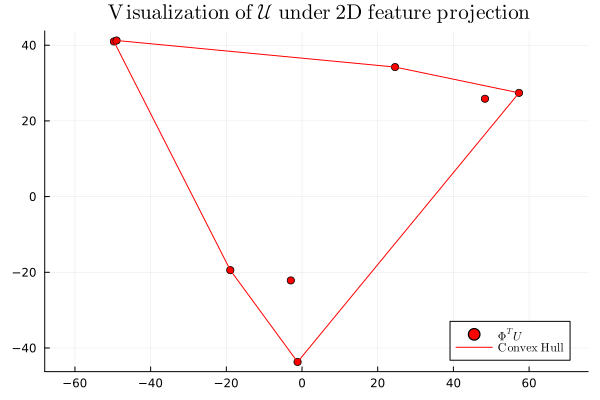

In [6]:
proj = Φ' * UM

plot_of_U = plot(aspectratio=1, background_color=:white, foreground_color=:black, grid_color=:blue, legend=:bottomright) # Light mode plot 😡
draw_convex_hull(proj, plot_of_U, "red", L"Φ^TU")
plot!(plot_of_U, 1,1,color=:red, label=L"\mathrm{Convex\ Hull}", title=L"\mathrm{\ Visualization\ of\ } \mathcal{U} \mathrm{\ under\ 2D\ feature\ projection}")
savefig(plot_of_U, "./plots/visual_U.pdf")
plot_of_U


## Define the expert

In [47]:
function πₑ(state)
	if (state == 1)
		return 1 # Take action 1 in state 1
	end
	return 2
end

# Find the occupancy frequency of the expert for later plotting
s1e = P[1, :, πₑ(1)]
s2e = P[2, :, πₑ(2)]
s3e = P[3, :, πₑ(3)]
Pₑ = cat(s1e, s2e, s3e, dims=2)'
d = (I - γ * Pₑ') \ p₀
Uₑ = zeros((length(S), length(A)))
for s ∈ S
	for a ∈ A # Assuming |A| uniform across states
		Uₑ[s,a] = d[s] .* (πₑ(s) == a)
	end
end
Uₑ = vec(reduce(hcat, Uₑ))

dLen = 1
D = construct_dataset(dLen, πₑ, S, P, p₀)

1-element Vector{Any}:
 (2, 2)

## Construct the set $\Upsilon$


In [48]:
Υ = construct_upsilon(UM, S, A, D)

# Υ is a matrix with SA rows
# each col υ ∈ Υ is a occupancy frequency
display(Υ)

6×4 Matrix{Float64}:
 70.8893   0.0     70.6189     0.0
  0.0      0.0      0.0        0.0
  0.2     31.0712   0.0        0.0
  0.0     38.9787   0.0       24.4431
 28.9107  29.9501  28.7296    11.847
  0.0      0.0      0.651466  63.7099

## Lets put $U$ and $\Upsilon$ together!

D = Any[(2, 2)]


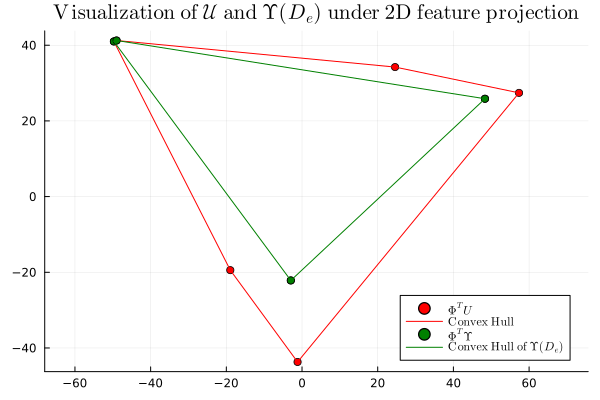

In [49]:
function plot_U_and_Upsilon(D) 
    Υ = construct_upsilon(UM, S, A, D)
    proj = Φ' * Υ
    # Float64.(reduce(hcat, vec.(X))) Converts vector of matrix to matrix 
    plot_of_U_and_Upsilon = plot(plot_of_U, aspectratio=1, background_color=:white, foreground_color=:black, grid_color=:blue, legend=:bottomright) # Light mode plot 😡 

    draw_convex_hull(proj, plot_of_U_and_Upsilon, "green", L"Φ^TΥ")

    plot!(plot_of_U_and_Upsilon,1, 1, color=:green, label=L"\mathrm{Convex\ Hull\ of\ } Υ(D_e)", title=L"\mathrm{Visualization\ of\ } \mathcal{U} \mathrm{\ and\ } Υ(D_e) \mathrm{\ under\ 2D\ feature\ projection}")
    plot_of_U_and_Upsilon
end
@show D
plot_of_U_and_Upsilon = plot_U_and_Upsilon(D)
savefig(plot_of_U_and_Upsilon, "./plots/visual_U_and_Upsilon.pdf")
plot_of_U_and_Upsilon

## Solve for the chebeyshev center
This is the tough bit

In [50]:
radius, optimalOccFreq = solve_cheb(Φ, S, A, p₀, γ, P, D)

c = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
(value.(u))' * c = 0.0
value.(α) = [0.8193834139376719, -0.41178416048185795]


(49.02605105781431, [8.118486182871623, 0.0, 22.913989757431537, 32.352644086982075, 27.138318541254222, 9.476561431460157])

# Visualization of the Chebyshev Center

radius = 49.02605105781431
optimalOccFreq = [8.118486182871623, 0.0, 22.913989757431537, 32.352644086982075, 27.138318541254222, 9.476561431460157]
D = Any[(2, 2)]


Uₑ = [70.6189391747475, 0.0, 0.0, 0.0, 28.72959502720652, 0.6514657980456026]


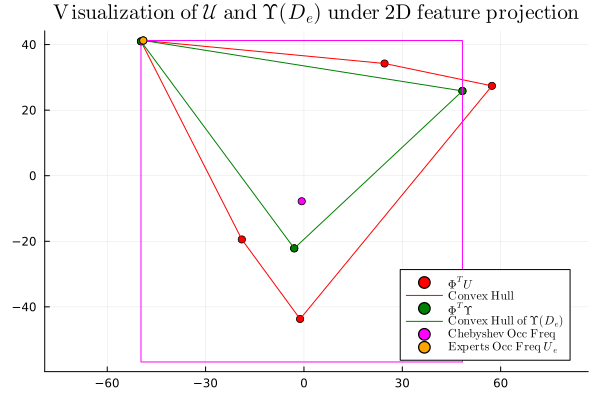

In [51]:
# Helper function to L_Inf norm rectangle
function plot_l_inf_norm(center, radius)
    B = BallInf(center, radius)
    vertices = vertices_list(B)
    vertices = reduce(hcat, vertices)
    # For some reason you have to swap the last two columns
    tmp = vertices[:, 4]
    vertices[:, 4] = vertices[:, 3]
    vertices[:, 3] = tmp
    # then duplicate the first vertex at the end
    vertices = hcat(vertices, vertices[:,1])
    vertices[1,:], vertices[2,:]
end

plot_of_U_and_Upsilon = plot_U_and_Upsilon(D)

@show radius
@show optimalOccFreq
@show D

# Add the optimalOccFreq to the plot along with σ
proj = Φ'*optimalOccFreq
pl = scatter(plot_of_U_and_Upsilon, (proj[1], proj[2]), color=:magenta, label=L"\mathrm{Chebyshev\ Occ\ Freq}")
plot!(pl, plot_l_inf_norm(proj, radius), color=:magenta, label="")

# For context add the experts occupancy frequency to the plot
@show Uₑ
proj = Φ'*Uₑ
scatter!(pl, (proj[1], proj[2]), color=:orange, label=L"\mathrm{Experts\ Occ\ Freq\ } U_e")
savefig(pl, "./plots/visual_solve_cheb.pdf")
pl


## Try different dataset sizes and states

c = [0.0, 0.0, 1.0, 1.0, 0.0, 0.0]


(value.(u))' * c = 20.99241525131202
value.(α) = [2.2134328357135544, -0.6295724024071632]
radius = 36.79656988864884
norm(Uₑ - optimalOccFreq) = 56.757517629191966


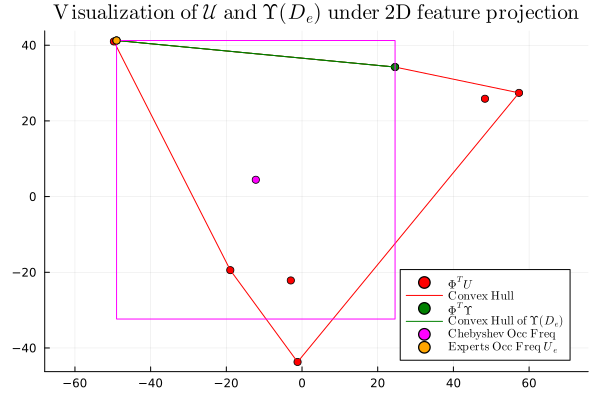

In [52]:
include("visual_helpers.jl")
D = [(3,2), (1,1)]
plot_of_U_and_Upsilon = plot_U_and_Upsilon(D)
radius, optimalOccFreq = solve_cheb(Φ, S, A, p₀, γ, P, D)
@show radius

# Add the optimalOccFreq to the plot along with σ
proj = Φ'*optimalOccFreq
pl = scatter(plot_of_U_and_Upsilon, (proj[1], proj[2]), color=:magenta, label=L"\mathrm{Chebyshev\ Occ\ Freq}")
plot!(pl, plot_l_inf_norm(proj, radius), color=:magenta, label="")

# For context add the experts occupancy frequency to the plot
@show norm(Uₑ - optimalOccFreq)
proj = Φ'*Uₑ
scatter!(pl, (proj[1], proj[2]), color=:orange, label=L"\mathrm{Experts\ Occ\ Freq\ } U_e")
savefig(pl, "./plots/visual_solve_cheb_outside_upsilon.pdf")
pl

## Visualization of the Lp Norm

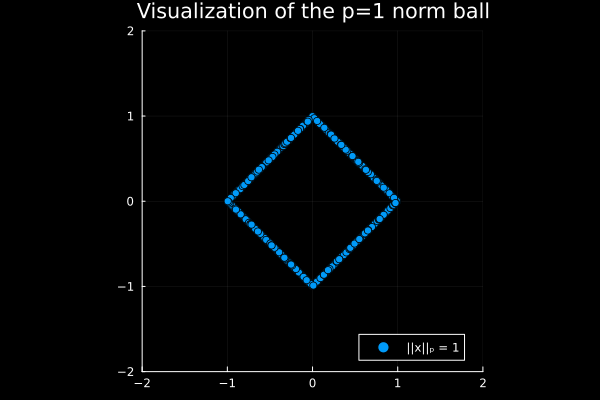

In [12]:
trials = 100_000
p = 1

h = [rand(range(-1, 1, step=1e-16), 2) for _ in 1:trials]
h = filter(h -> norm(h,p) >= .99 && norm(h,p) <= 1.001, h)

x = [h[n][1] for n in range(1, length(h))]
y = [h[n][2] for n in range(1, length(h))]
scatter(x, y, label="||x||ₚ = 1")
plot!(xlim=(-2, 2), ylim=(-2, 2), 
    aspectratio=1, background_color=:black, foreground_color=:white, grid_color=:blue) # Dark mode plot 🙂
plot!(title="Visualization of the p=$p norm ball")